In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.array as da
import pandas as pd

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [147]:
# importing segmentation algorithm
os.chdir('/w2-data2/willytsai/python_module')
from SCAI_calc4obj import labeled_obj, label_remove

In [4]:
MERRA2_dir = '/w2-data2/willytsai/MERRA2/inst_2d_hourly'
os.chdir(MERRA2_dir)

In [5]:
files = glob('*2014*')+glob('*2015*')#+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one

In [6]:
cwv_data = cwv_data.sel(lat=slice(-10,10),lon=slice(30,100)) # selecting region
lon = cwv_data.lon
lat = cwv_data.lat
TQV = cwv_data.TQV

In [7]:
TRMM_dir = '/w2-data2/willytsai/TRMM_3hr/TRMM/2009_2018'
os.chdir(TRMM_dir)
files = sorted(glob('*2014*')+glob('*2015*'))#+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018

times = pd.date_range('2014-01-01-00',periods=len(files),freq='3H')

In [8]:
%%time
prec_data = np.zeros((len(files),241,1440))
for n,file in enumerate(files):
    tmp = xr.open_dataset(file)
    prec_data[n,:,:] = tmp.precipitation.values.swapaxes(0,1) 

CPU times: user 1min 31s, sys: 37.5 s, total: 2min 9s
Wall time: 3min 22s


In [9]:
lon_tmp = tmp.nlon
lat_tmp = tmp.nlat
prec_xr = xr.DataArray(prec_data,coords=[times,lat_tmp,lon_tmp],dims=['time','nlat','nlon'])

In [10]:
prec_trmm = prec_xr.sel(nlat=slice(-10,10),nlon=slice(30,100))

In [11]:
land_msk = xr.open_dataset(MERRA2_dir+'/../landmask_MERRA2.nc')
lsm = land_msk.sel(lat=slice(-10,10),lon=slice(30,100)).lsm[0,:,:] # landmask, 30N-30S

In [12]:
land_msk = xr.open_dataset('/w2-data2/willytsai/WEIO_VaporLakes/landmask_TRMM.nc')
lsm_trmm = xr.DataArray(land_msk.lsm[0,:,:].values,coords=[prec_xr.nlat,prec_xr.nlon],dims=['nlat','nlon'])

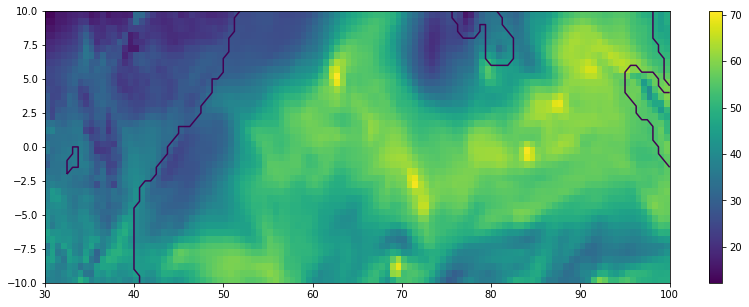

In [13]:
fig = plt.figure(figsize=(14,5))
plt.pcolor(lon,lat,TQV[0,:,:])
plt.colorbar()
plt.contour(lon,lat,lsm,levels=[1])

In [14]:
maskweight = -lsm.sel(lon=slice(38,52),lat=slice(-10,10)).diff('lon')
TQV_WEIO = (TQV.sel(lon=slice(38,52),lat=slice(-10,10))*maskweight).sum(dim='lon') # EA coastline 

In [15]:
maskweight2 = -lsm_trmm.sel(nlon=slice(38,52),nlat=slice(-10,10)).diff('nlon')
prec_WEIO = (prec_xr.sel(nlon=slice(38,52),nlat=slice(-10,10))*maskweight2).sum(dim='nlon') # EA coastline 

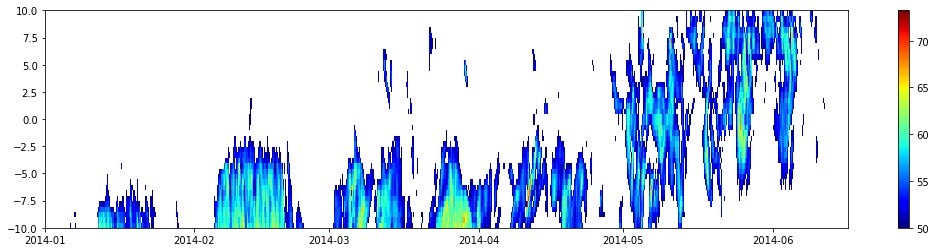

In [16]:
fig = plt.figure(figsize=(18,4))
plt.pcolormesh(TQV_WEIO.time.values[:4000],TQV_WEIO.lat.values,TQV_WEIO[:4000,:].T,vmin=50,cmap='jet')
cbar = plt.colorbar()
cbar.cmap.set_under('w')

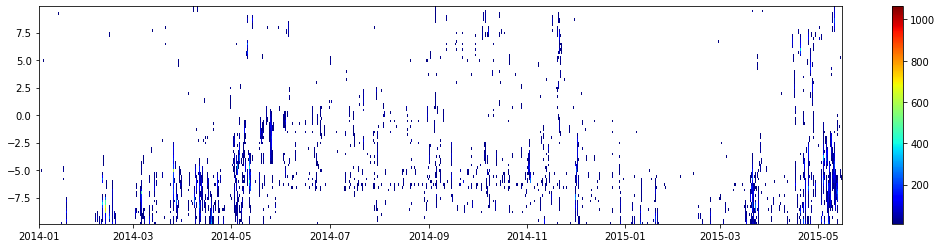

In [17]:
fig = plt.figure(figsize=(18,4))
plt.pcolormesh(prec_WEIO.time.values[:4000],prec_WEIO.nlat.values,24*prec_WEIO[:4000,:].T,vmin=10,cmap='jet')
cbar = plt.colorbar()
cbar.cmap.set_under('w')

### start testing segmentation

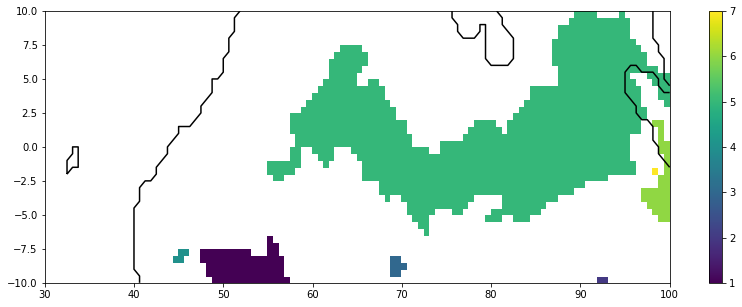

In [18]:
fig = plt.figure(figsize=(14,5))

labeled_pix, num = labeled_obj(TQV[0,:,:],55,1)
plt.pcolor(lon,lat,labeled_pix,vmin=1)
cbar = plt.colorbar()
cbar.cmap.set_under('w') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])

Text(0.5, 1.0, 'current')

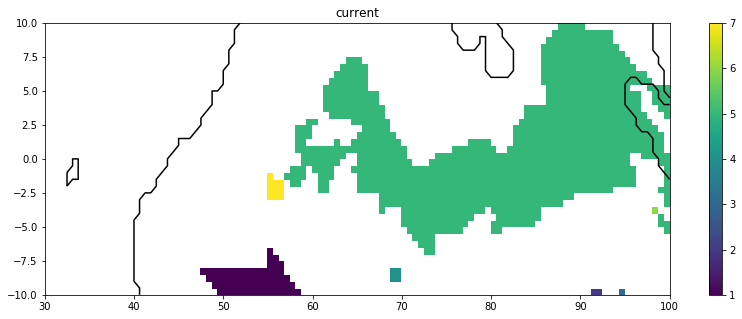

In [19]:
fig = plt.figure(figsize=(14,5))

labeled_pix, num = labeled_obj(TQV[5,:,:],55,1)
plt.pcolor(lon,lat,labeled_pix,vmin=1)
cbar = plt.colorbar()
cbar.cmap.set_under('w') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])
plt.title('current')

In [20]:
current_array, current_num = labeled_obj(TQV[5,:,:],55,1)
post_array,post_num = labeled_obj(TQV[1,:,:],55,1)

overlapped_mask = np.copy(current_array)
overlapped_mask[post_array*current_array==0] = 0 # overlapped pixels

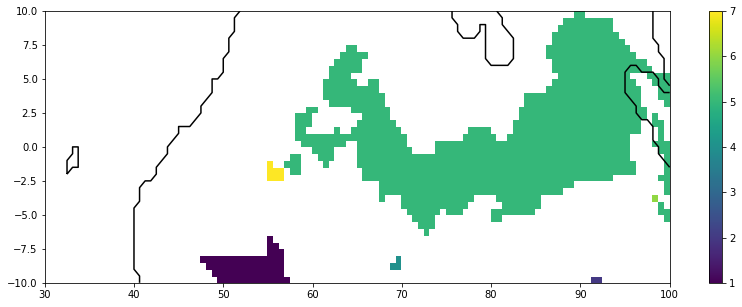

In [21]:
fig = plt.figure(figsize=(14,5))
plt.pcolor(lon,lat,overlapped_mask,vmin=1)
cbar = plt.colorbar()
cbar.cmap.set_under('w') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])

In [22]:
# def relabel_pixels(post_array,current_array,current_num,post_num): 

#     new_array = np.copy(post_array)*0 # new array for 
    
#     # detecting connection for each labeled objects in the last timestep
#     for label in range(1,len(post_num)+1):
#         label_mask = np.copy(current_array)
#         label_mask[label_mask != label] = 0 # extract only the specfic object by labeled number

#         if len(np.where(label_mask*post_array>0))>0: # decide if overlapped 
#             idx,idy = np.where(label_mask*post_array>0)
#             old_label = current_array[idx[0],idy[0]] # extract old label
#             print(old_label)
            
#             for i,j in zip(idx,idy):
#                 new_array[i,j] = old_label # done repalce 
                
                

In [116]:
def get_centroid(input_labeled_array,label,lon,lat):
    
    idy,idx = np.where(input_labeled_array == label)
    
    return lon[idx].mean().values, lat[idy].mean().values
    
def get_bounds(input_labeled_array,label):
    
    idx,idy = np.where(input_labeled_array == label)
    
    return (idx.max(),idx.min(),idy.max(),idy.min())

In [234]:
array_save = np.zeros((10,41,113)) # save labeled array at each time 
array_ori = np.zeros((10,41,113)) # original labeled array at each time
unused_label = np.arange(100000) # list used_label for double check
timestamp = []
x_cen = []
y_cen = []
label_tag = []

step = 0
for t in np.arange(10,3,-1): # [10..5..1]
    
    if step == 0:
        current_array, current_num = labeled_obj(TQV[t,:,:],55,1) # first scene
        current_array, current_num = label_remove(current_array,current_num,connect_min=2)
    else:
        current_array = new_array 
        
    post_array,post_num = labeled_obj(TQV[t-1,:,:],55,1)
    post_array, post_num = label_remove(post_array,post_num,connect_min=2)    
    
    new_array = np.copy(post_array)*0 # new array 
    tbd_array = np.copy(post_array)

    # detecting connection for each randomly labeled objects in the last timestep
    for label in range(1,post_num+1):
        label_mask = np.copy(post_array)
        label_mask[label_mask != label] = 0 # extract only the specfic object by labeled number

        if len(np.where(label_mask*current_array>0)[0])>0: # decide if overlapped between labeled obj and the old imagrey
            idx,idy = np.where(label_mask*current_array>0)
            old_label = current_array[idx[0],idy[0]] # extract old label

            # replace random labels by old labels if overlapped
            new_array[post_array==label] = old_label
            tbd_array[new_array==old_label] = 0 # marked relabeled as 0, remaining tbd objects
    
    # update unused_label
    unused_label = np.setdiff1d(unused_label,np.unique(new_array)[1:])
    
    #relabel isolated, new objectes with unused_label
    #print(new_label[:3])
    tbd_label = np.unique(tbd_array)[1:]
    #print(np.unique(tbd_array)[1:])
    for n,nl in enumerate(tbd_label):
        label_mask = np.copy(tbd_array)
        new_array[label_mask == nl] = unused_label[n] # extract only the specfic object by labeled number
    
    for label_re in np.unique(new_array)[1:]:
        tmp1, tmp2 = get_centroid(new_array,label_re,lon,lat)
        
        timestamp.append(t-1)
        x_cen.append(tmp1)
        y_cen.append(tmp2)
        label_tag.append(label_re)
        #get_bounds(new_array,label_re)
    
    #checking if ALL objects were detected and are labeled
    #for t_check in range(t-1):
    #    used_label = np.intersect1d(used_label, np.unique(array_save(t_check,:,:)))
    
    array_save[t-1,:,:] = new_array
    array_ori[t-1,:,:] = post_array
    step += 1
    

In [217]:
a = np.unique(new_array)[1:]
a

array([1, 2, 3, 4, 5], dtype=int32)

In [219]:
np.setdiff1d(test,a)

array([6, 7, 8, 9])

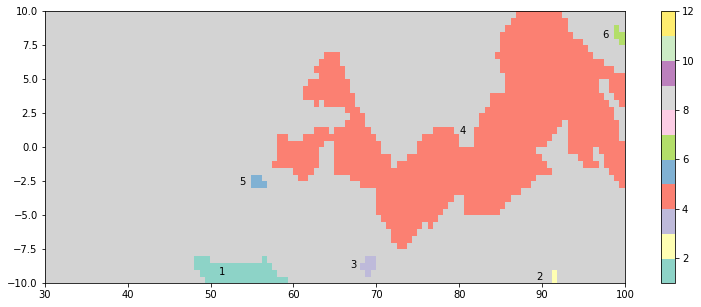

In [186]:
x_cen = []
y_cen = []
label_tag = []

cmap_jet = plt.get_cmap('Set3', 11)
current_array, current_num = labeled_obj(TQV[9,:,:],55,1)
current_array, current_num = label_remove(current_array,current_num,connect_min=2)
fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,current_array,vmin=1,vmax=12,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('lightgrey') # set color white for 0

for label_re in np.unique(current_array)[1:]:
    tmp1, tmp2 = get_centroid(current_array,label_re,lon,lat)
    x_cen.append(tmp1)
    y_cen.append(tmp2)
    label_tag.append(label_re)
    
for x,y,tag in zip(x_cen,y_cen,label_tag):
    plt.text(x-2,y,str(tag))

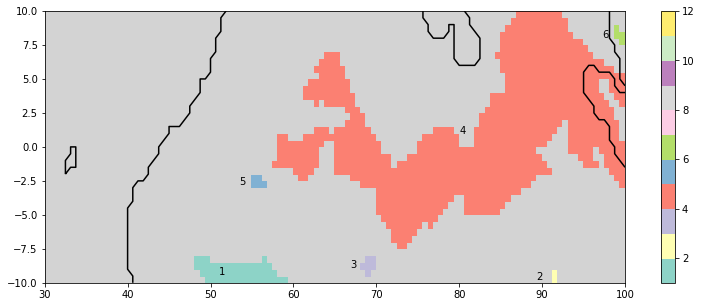

In [240]:
t = 9

fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[t,:,:],vmin=1,vmax=12,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('lightgrey') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])

idx = np.where(np.asarray(timestamp)==t)
for x,y,tag in zip(np.asarray(x_cen)[idx],np.asarray(y_cen)[idx],np.asarray(label_tag)[idx]):
    plt.text(x-2,y,str(tag))

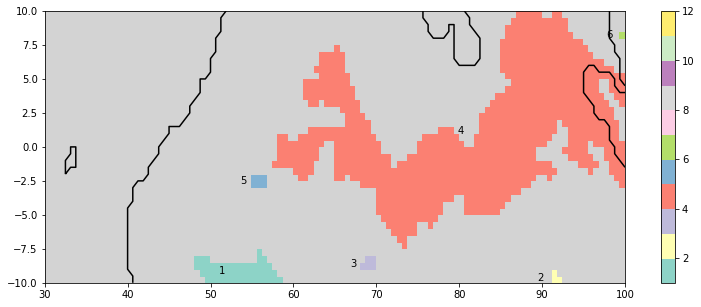

In [241]:
t = 8

fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[t,:,:],vmin=1,vmax=12,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('lightgrey') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])

idx = np.where(np.asarray(timestamp)==t)
for x,y,tag in zip(np.asarray(x_cen)[idx],np.asarray(y_cen)[idx],np.asarray(label_tag)[idx]):
    plt.text(x-2,y,str(tag))

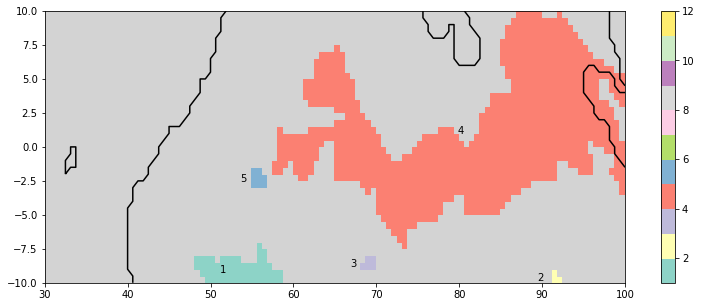

In [242]:
t = 7

fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[t,:,:],vmin=1,vmax=12,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('lightgrey') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])

idx = np.where(np.asarray(timestamp)==t)
for x,y,tag in zip(np.asarray(x_cen)[idx],np.asarray(y_cen)[idx],np.asarray(label_tag)[idx]):
    plt.text(x-2,y,str(tag))

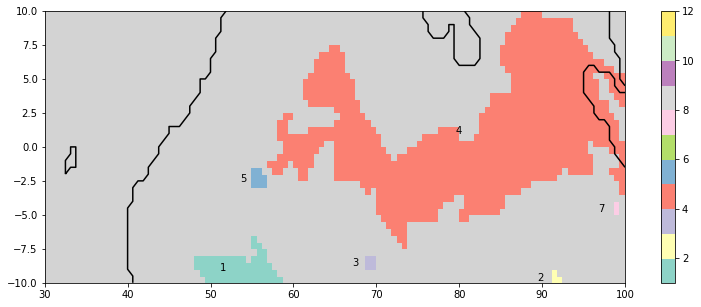

In [243]:
t = 6

fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[t,:,:],vmin=1,vmax=12,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('lightgrey') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])

idx = np.where(np.asarray(timestamp)==t)
for x,y,tag in zip(np.asarray(x_cen)[idx],np.asarray(y_cen)[idx],np.asarray(label_tag)[idx]):
    plt.text(x-2,y,str(tag))

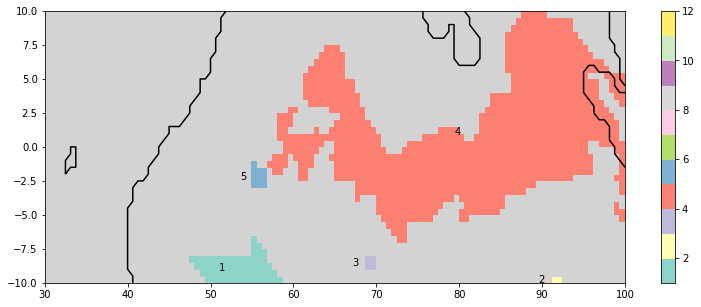

In [244]:
t = 5

fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[t,:,:],vmin=1,vmax=12,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('lightgrey') # set color white for 0
plt.contour(lon,lat,lsm,levels=[1],colors=['k'])

idx = np.where(np.asarray(timestamp)==t)
for x,y,tag in zip(np.asarray(x_cen)[idx],np.asarray(y_cen)[idx],np.asarray(label_tag)[idx]):
    plt.text(x-2,y,str(tag))
    

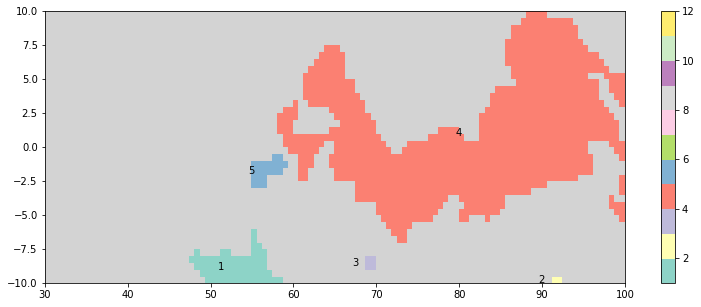

In [233]:
t = 4

fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[t,:,:],vmin=1,vmax=12,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('lightgrey') # set color white for 0

idx = np.where(np.asarray(timestamp)==t)
for x,y,tag in zip(np.asarray(x_cen)[idx],np.asarray(y_cen)[idx],np.asarray(label_tag)[idx]):
    plt.text(x-2,y,str(tag))

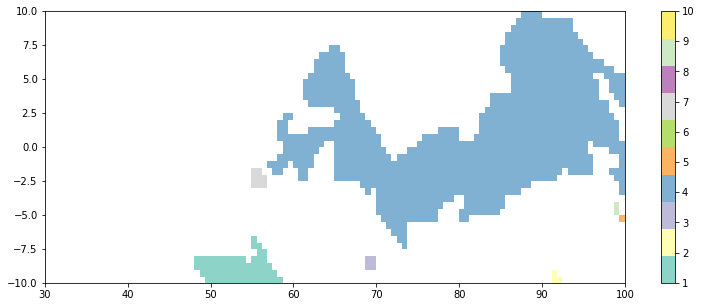

In [46]:
fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[6,:,:],vmin=1,vmax=10,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('w') # set color white for 0

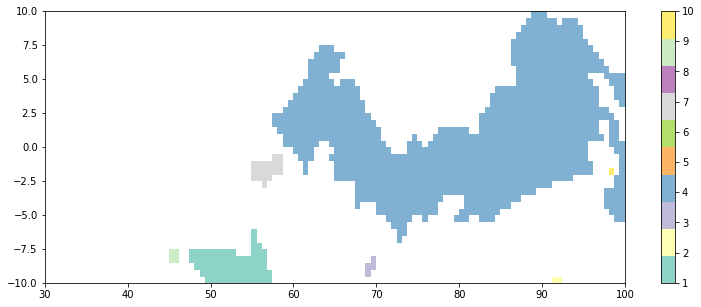

In [47]:
fig = plt.figure(figsize=(13,5))
plt.pcolor(lon,lat,array_save[2,:,:],vmin=1,vmax=10,cmap=cmap_jet)
cbar = plt.colorbar()
cbar.cmap.set_under('w') # set color white for 0